In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('/Users/yaguethiam/Ponts/data_prepared_ponts_v4.csv')

##### nombre de place moyen Salle cinema : 300

In [8]:
data['sales'].describe()

count    6.676000e+03
mean     1.927583e+05
std      3.454426e+05
min      3.500000e+01
25%      2.397000e+04
50%      7.379700e+04
75%      2.051368e+05
max      4.378720e+06
Name: sales, dtype: float64

In [9]:
min(data['sales']), max(data['sales'])

(35, 4378720)

### Run model 

#### Functions

In [82]:
def prepare_data(data):
    data = data.dropna()
    data = data.query("year != 2020")
    data = data.sort_values(by='release_date')
    data.release_date = pd.to_datetime(data.release_date)
    data.index = data.release_date
    y = data.sales
    y = y.astype(float)
    X = data.drop(columns=['index', 'year', 'sales', 'release_date'], errors='ignore')
    return X,y

In [6]:
from sklearn.model_selection import train_test_split

def train_test_split_by_date(df: pd.DataFrame, split_date: str):
    """Split dataset according to a split date in format "YYYY-MM-DD"
    - train: [:split_date[
    - test: [split_date:]
    """
    train = df.loc[:split_date].copy()
    test = df.loc[split_date:].copy()
    return train, test

In [7]:
X_train, X_test = train_test_split_by_date(X, '2018-01-01')
y_train, y_test = train_test_split_by_date(y, '2018-01-01')

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics._regression import _check_reg_targets

def mean_absolute_percentage_error(y_true, y_pred):
    """in percent"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def get_evaluation_metrics(y_test, y_pred, y_train=None) -> dict:
    metrics = {
        'mape': mean_absolute_percentage_error(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred, squared=True),
        'rmse': mean_squared_error(y_test, y_pred, squared=False),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
    }
    return metrics


def prettify_metrics(metrics: dict) -> str:
    output = [f"Evaluation:\n{'-'*10}"]
    for name, metric in metrics.items():
        output.append((f'- {name.upper()}: {round(metric, 2)}'))
    return '\n'.join(output)

In [12]:
from lightgbm import LGBMRegressor

In [13]:
# Let's compare the performance with the previous model. 
lgbm = LGBMRegressor().fit(X_train, y_train)
yhat = lgbm.predict(X_test)
print(prettify_metrics(get_evaluation_metrics(y_test, yhat)))

Evaluation:
----------
- MAPE: 986.91
- MSE: 47208306381.14
- RMSE: 217274.73
- MAE: 115518.99
- R2: 0.59


In [14]:
lgbm_feature_imp = pd.DataFrame(lgbm.feature_importances_, X_train.columns, columns=['importance'])

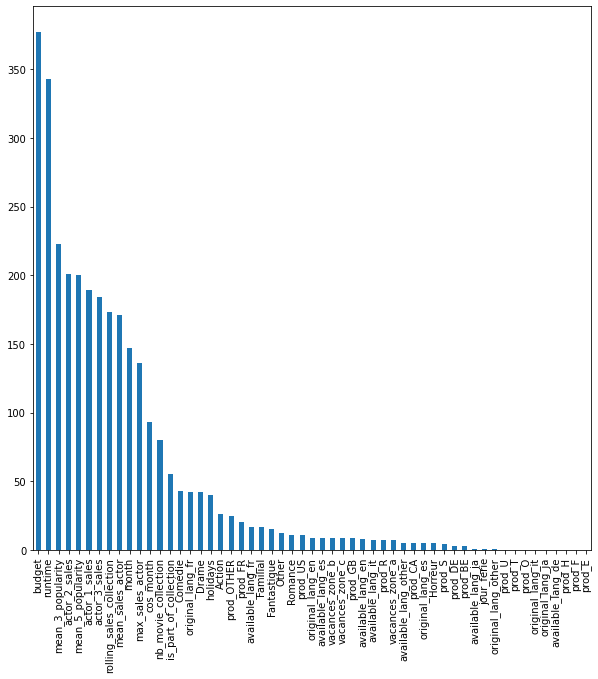

In [15]:
lgbm_feature_imp.importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,10))

#### Choosing top best set of variables

In [17]:
sorted_feat = lgbm_feature_imp.importance.sort_values(ascending=False)

In [42]:
mape = []
for i in range(5, len(sorted_feat)):
    feat_to_keep = list(sorted_feat.head(i).index)
    lgbm = LGBMRegressor().fit(X_train[feat_to_keep], y_train)
    yhat = lgbm.predict(X_test[feat_to_keep])
    mape_i = mean_absolute_percentage_error(y_test, yhat)
    mape.append(mape_i)

In [48]:
results = pd.DataFrame({'num_features':range(5, len(sorted_feat)),
              "mape": mape})

results.index = results.num_features
results.drop('num_features', axis=1, inplace=True)

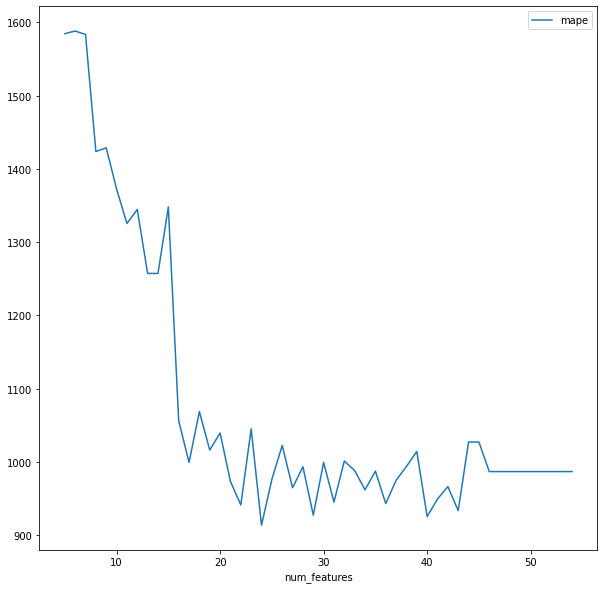

In [51]:
results.plot(figsize=(10,10))

In [66]:
feat_to_keep = list(sorted_feat.head(24).index)
lgbm = LGBMRegressor().fit(X_train[feat_to_keep], y_train)
yhat = lgbm.predict(X_test[feat_to_keep])
print(prettify_metrics(get_evaluation_metrics(y_test, yhat)))

Evaluation:
----------
- MAPE: 913.74
- MSE: 47814045542.59
- RMSE: 218664.23
- MAE: 115751.39
- R2: 0.59


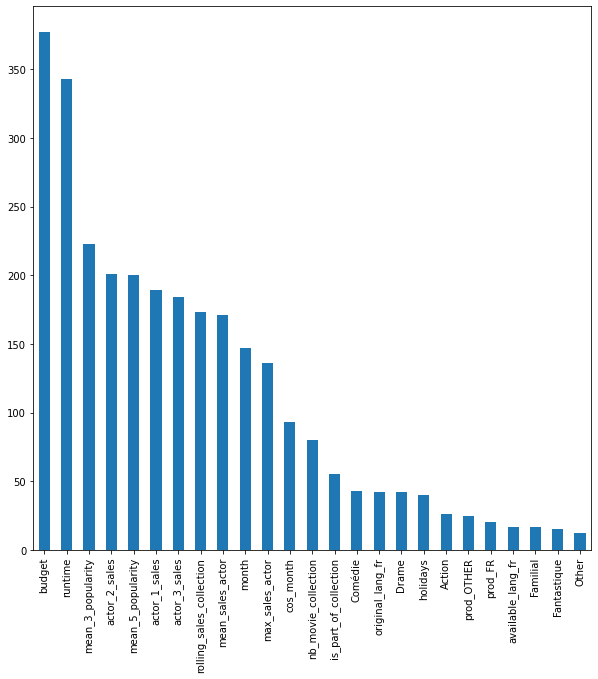

In [67]:
lgbm_feature_imp.importance.sort_values(ascending=False)[:25].plot(kind='bar', figsize=(10,10))

### Curate data from outliers

In [89]:
data_raw.sales.describe()

count    6.676000e+03
mean     1.927583e+05
std      3.454426e+05
min      3.500000e+01
25%      2.397000e+04
50%      7.379700e+04
75%      2.051368e+05
max      4.378720e+06
Name: sales, dtype: float64

> #### Let's assume that a movie would fill at least a "salle" when it is out. So we can filter out the movies with less than 300 entries and consider those who doesnt as outliers. 
To discriminate movies, we could start with a classifier that says whether the movie will fill multiple "salle" or not and if it does then we would predict the number of sales for that movie with our algorithm

In [84]:
data_rm = data_raw.query("sales >= 300")

In [85]:
data_rm.shape, data.shape

((6634, 59), (6526, 59))

In [86]:
X,y = prepare_data(data_rm)

X_train, X_test = train_test_split_by_date(X, '2018-01-01')
y_train, y_test = train_test_split_by_date(y, '2018-01-01')

In [88]:
feat_to_keep = list(sorted_feat.head(24).index)
lgbm = LGBMRegressor().fit(X_train[feat_to_keep], y_train)
yhat = lgbm.predict(X_test[feat_to_keep])
print(prettify_metrics(get_evaluation_metrics(y_test, yhat)))

Evaluation:
----------
- MAPE: 481.63
- MSE: 48369439395.63
- RMSE: 219930.53
- MAE: 116626.43
- R2: 0.59


### Scaling Budget

In [91]:
data_rm['budget'] = data_rm['budget']/data_rm['budget'].max()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
X,y = prepare_data(data_rm)

X_train, X_test = train_test_split_by_date(X, '2018-01-01')
y_train, y_test = train_test_split_by_date(y, '2018-01-01')

In [94]:
feat_to_keep = list(sorted_feat.head(24).index)
lgbm = LGBMRegressor().fit(X_train[feat_to_keep], y_train)
yhat = lgbm.predict(X_test[feat_to_keep])
print(prettify_metrics(get_evaluation_metrics(y_test, yhat)))

Evaluation:
----------
- MAPE: 481.63
- MSE: 48369439395.63
- RMSE: 219930.53
- MAE: 116626.43
- R2: 0.59


### Target variable distribution

In [113]:
data_rm = data_raw.query("sales >= 300")

In [97]:
data_rm.sales.max()/data_rm.sales.std()

12.648188643867597

In [103]:
bin_values = np.arange(start=0, stop=int(data_rm.sales.max())+1000, step=int(data_rm.sales.std())/100)

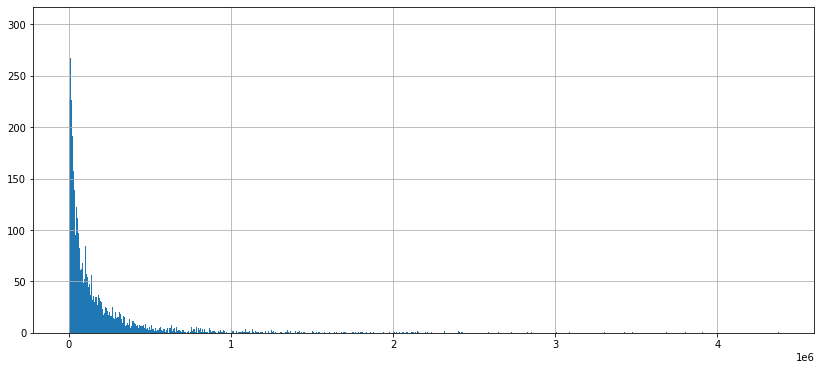

In [105]:
data_rm.sales.hist(bins=bin_values, figsize=[14,6])

- ## Look like an exponetial --> take the log

### Mean normalization

In [114]:
data_rm.sales.describe()

count    6.634000e+03
mean     1.939775e+05
std      3.461934e+05
min      3.060000e+02
25%      2.447375e+04
50%      7.463450e+04
75%      2.063865e+05
max      4.378720e+06
Name: sales, dtype: float64

In [115]:
mean_drm = data_rm.sales.mean()
std_drm = data_rm.sales.std()

In [116]:
data_rm.sales = (data_rm.sales - mean_drm)/std_drm

In [117]:
data_rm.sales.describe()

count    6.634000e+03
mean    -4.284249e-18
std      1.000000e+00
min     -5.594315e-01
25%     -4.896215e-01
50%     -3.447293e-01
75%      3.584409e-02
max      1.208787e+01
Name: sales, dtype: float64

In [119]:
bin_values = np.arange(start=data_rm.sales.min(), stop=data_rm.sales.max(), step=0.01)

In [122]:
data_rm.sales.max()

12.087873261538702

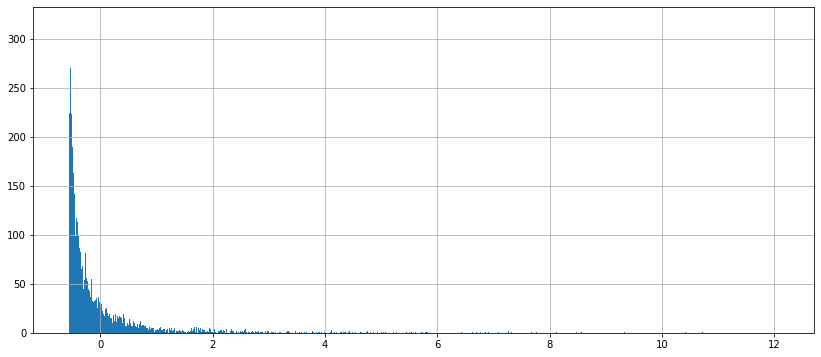

In [121]:
data_rm.sales.hist(bins=bin_values, figsize=[14,6])

### Why and  How do we evaluate: choose a metrics/loss?

- metrics: measures the performance of the model on the validation set. For us to assess the quality of the model

- loss: measures the performance of the model during training. How much optimizing the model with the data has helped improve its performance

#### Best metrics = MAPE

### Redo model evaluation

### Validate a model

### Model Optimization

In [ ]:
Why? How?

In [ ]:
Variable selection, hyperparameter selection, ....

### Regularization